In [1]:
!pip3 install -q -U bitsandbytes==0.42.0
!pip3 install -q -U peft==0.8.2
!pip3 install -q -U trl==0.7.10
!pip3 install -q -U accelerate
!pip3 install -q -U datasets
!pip3 install -q -U transformers

In [2]:
# taken reference from https://huggingface.co/blog/gemma-peft

from peft import LoraConfig

lora_config = LoraConfig(
    r=8,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
    task_type="CAUSAL_LM",
)

In [3]:
lora_config

LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type='CAUSAL_LM', inference_mode=False, r=8, target_modules={'q_proj', 'up_proj', 'down_proj', 'gate_proj', 'v_proj', 'k_proj', 'o_proj'}, lora_alpha=8, lora_dropout=0.0, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={})

# Loading Models and Tokenizers

In [4]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import os
from google.colab import userdata


os.environ["HF_TOKEN"] = userdata.get('HF_TOKEN_READ')
model_id = "google/gemma-2b-it"
bnb_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16)

tokenizer = AutoTokenizer.from_pretrained(model_id, token=os.environ['HF_TOKEN'])
model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, device_map='auto', token=os.environ['HF_TOKEN'])

Gemma's activation function should be approximate GeLU and not exact GeLU.
Changing the activation function to `gelu_pytorch_tanh`.if you want to use the legacy `gelu`, edit the `model.config` to set `hidden_activation=gelu`   instead of `hidden_act`. See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

# Data Pre-processing

In [8]:
from datasets import load_dataset

# taken reference from code of Independent Project at MIDAS Lab written by Chayan Tank at IIIT Delhi
data = load_dataset('csv', data_files = {'train':'/content/scifi_train.csv',
                                  'validation':'/content/scifi_val.csv',
                                  'test':'/content/scifi_test.csv'})

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [9]:
training_data = data['train']
validation_data = data['validation']
testing_data = data['test']

In [10]:
# taken reference from https://adithyask.medium.com/a-beginners-guide-to-fine-tuning-gemma-0444d46d821c

def generate_prompt(data):
    prefix_text = 'Below is an instruction that describes a task. Write a response that appropriately completes the request.\\n\\n'
    instruction = 'Generate an scifi story given the beginning of the story: '
    if data['Prompt']:
        text = f"""<start_of_turn>user {prefix_text} {instruction} {data["Prompt"]} <end_of_turn>\\n<start_of_turn>model {data["Story"]} <end_of_turn>"""
    else:
        text = f"""<start_of_turn>user {prefix_text} {instruction} <end_of_turn>\\n<start_of_turn>model {data["Story"]} <end_of_turn>"""
    return text

training_text_column = []
for i in range(len(training_data)):
  training_text_column.append(generate_prompt(training_data[i]))

validation_text_column = []
for i in range(len(validation_data)):
  validation_text_column.append(generate_prompt(validation_data[i]))

testing_text_column = []
for i in range(len(testing_data)):
  testing_text_column.append(generate_prompt(testing_data[i]))

training_dataset = training_data.add_column("prompt", training_text_column)
validation_dataset = validation_data.add_column("prompt", validation_text_column)
testing_dataset = validation_data.add_column("prompt", testing_text_column)

In [11]:
# taken reference from https://adithyask.medium.com/a-beginners-guide-to-fine-tuning-gemma-0444d46d821c

training_tokens = training_dataset.map(lambda samples: tokenizer(samples["prompt"], max_length=1000), batched=True)
validation_tokens = validation_dataset.map(lambda samples: tokenizer(samples["prompt"], max_length=1000), batched=True)
testing_tokens = testing_dataset.map(lambda samples: tokenizer(samples["prompt"], max_length=1000), batched=True)

Map:   0%|          | 0/9 [00:00<?, ? examples/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

# Model Training

In [12]:
!pip install git+https://github.com/huggingface/trl.git@7630f877f91c556d9e5a3baa4b6e2894d90ff84c

  Cloning https://github.com/huggingface/trl.git (to revision 7630f877f91c556d9e5a3baa4b6e2894d90ff84c) to /tmp/pip-req-build-_ovyd9f_
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/trl.git /tmp/pip-req-build-_ovyd9f_
  Running command git rev-parse -q --verify 'sha^7630f877f91c556d9e5a3baa4b6e2894d90ff84c'
  Running command git fetch -q https://github.com/huggingface/trl.git 7630f877f91c556d9e5a3baa4b6e2894d90ff84c
  Running command git checkout -q 7630f877f91c556d9e5a3baa4b6e2894d90ff84c
  Resolved https://github.com/huggingface/trl.git to commit 7630f877f91c556d9e5a3baa4b6e2894d90ff84c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for trl: filename=trl-0.7.12.dev0-py3-none-any.whl size=173433 sha256=3dc20839999369afe63e5c1f23e167a788219c520b9961d1c3c7b1631ecd4cfb
  Stored in directory: /root/.cache/pip/wheels/ad/f5/b1/f5ac48230936583c88cfde8

In [13]:
import transformers
from trl import SFTTrainer

# taken reference from https://adithyask.medium.com/a-beginners-guide-to-fine-tuning-gemma-0444d46d821c
tokenizer.pad_token = tokenizer.eos_token
model_trainer = SFTTrainer(
    model=model,
    train_dataset=training_tokens,
    eval_dataset=validation_tokens,
    dataset_text_field="prompt",
    args=transformers.TrainingArguments(
        per_device_train_batch_size=1,
        per_device_eval_batch_size=1,
        evaluation_strategy="epoch",
        gradient_accumulation_steps=4,
        warmup_steps=2,
        max_steps=10,
        learning_rate=1e-4,
        fp16=True,
        logging_steps=1,
        output_dir="scifi_story",
        optim="paged_adamw_8bit",
        num_train_epochs=4,
        logging_strategy='epoch'
    ),
    peft_config=lora_config
)
model_trainer.train()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:228: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/9 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:300: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss
0,3.268100,2.825038
1,3.122800,2.675298
2,2.905100,2.568890
4,2.408300,2.472749


TrainOutput(global_step=10, training_loss=2.6532547950744627, metrics={'train_runtime': 30.7666, 'train_samples_per_second': 1.3, 'train_steps_per_second': 0.325, 'total_flos': 186159303352320.0, 'train_loss': 2.6532547950744627, 'epoch': 4.44})

In [14]:
# from huggingface_hub import notebook_login

# notebook_login()

In [15]:
import torch
torch.cuda.empty_cache()

In [16]:
# taken reference from https://adithyask.medium.com/a-beginners-guide-to-fine-tuning-gemma-0444d46d821c
# taken reference from https://stackoverflow.com/questions/77547377/notimplementederror-cannot-copy-out-of-meta-tensor-no-data
from peft import PeftModel

# def get_device_map() -> str:
#     return 'cuda' if torch.cuda.is_available() else 'cpu'

device = 'cpu'

checkpoint = "Gemma-Scifi-Story"
model_trainer.model.save_pretrained(checkpoint)
base_model = AutoModelForCausalLM.from_pretrained(model_id,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map=device,
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [17]:
!apt install git-lfs

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [18]:
# taken reference from https://adithyask.medium.com/a-beginners-guide-to-fine-tuning-gemma-0444d46d821c
final_model= PeftModel.from_pretrained(base_model, checkpoint)
final_model= final_model.merge_and_unload()
final_model.save_pretrained("Gemma-Scifi-Story-V1" ,safe_serialization=True)
tokenizer.save_pretrained("Gemma-Scifi-Story-V1")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"


# Normal Evaluation

In [19]:
# taken reference from NLP Assignment 3 Code Done by Shaina Mehta

loss = model_trainer.state.log_history[:-1]
train_loss_dict = []
val_loss_dict = []
for i in range(len(loss)):
  if i%2 == 0:
    train_loss_dict.append(loss[i])
  else:
    val_loss_dict.append(loss[i])

In [20]:
train_loss = []
for i in range(len(train_loss_dict)):
  train_loss.append(train_loss_dict[i]['loss'])

In [21]:
val_loss = []
for i in range(len(val_loss_dict)):
  val_loss.append(val_loss_dict[i]['eval_loss'])

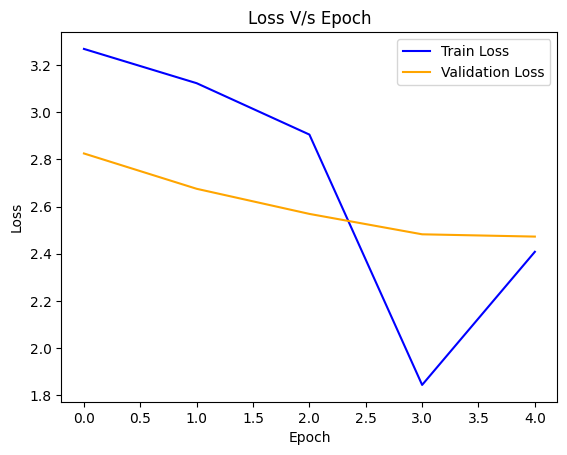

In [22]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(5)
train_loss = np.array(train_loss)
val_loss = np.array(val_loss)

plt.plot(x,train_loss,color='blue',label='Train Loss')
plt.plot(x,val_loss,color='orange',label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss V/s Epoch')
plt.show()

In [23]:
# taken reference from https://adithyask.medium.com/a-beginners-guide-to-fine-tuning-gemma-0444d46d821c

def story_generator(query, model, tokenizer):
  device = "cpu"
  prompt_template = """<start_of_turn>
  user
  Below is an instruction that describes a task. Write a response that appropriately completes the request.
  {query}
  <end_of_turn>\\n<start_of_turn> model

  """
  prompt = prompt_template.format(query=query)
  encoder = tokenizer(prompt, return_tensors="pt", add_special_tokens=True)
  model_inputs = encoder.to(device)
  generated_ids = model.generate(**model_inputs, max_new_tokens=5000, do_sample=True, pad_token_id=tokenizer.eos_token_id)
  decoded = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
  return (decoded)

In [24]:
my_tokenizer = transformers.AutoTokenizer.from_pretrained("/content/Gemma-Scifi-Story-V1")
my_model = transformers. AutoModelForCausalLM.from_pretrained("/content/Gemma-Scifi-Story-V1")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [25]:
actual = []
for i in range(len(testing_data)):
  actual.append('Generate an scifi story given the beginning of the story: '+testing_data[i]['Prompt'])
predicted = []
for i in range(len(testing_data)):
  predicted.append(story_generator(query=actual[i], model=my_model, tokenizer=my_tokenizer))

In [26]:
!pip install evaluate

In [27]:
import evaluate


perplexity = evaluate.load("perplexity", module_type="metric")
results = perplexity.compute(model_id='/content/Gemma-Scifi-Story-V1', add_start_token=False,
                             predictions=predicted, device='cpu')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [28]:
print('Perplexity: ',results['perplexities'])
print('Mean Perplexity: ',results['mean_perplexity'])

Perplexity:  [36.922271728515625, 34.66740036010742, 31.475244522094727]
Mean Perplexity:  34.35497220357259


In [29]:
# taken reference from NLP Assignment 3 Code Done by Shaina Mehta

def bleu_1(actual, predicts):
    decoded_actual = [act.strip() for act in actual]
    decoded_prediction = [pred.strip() for pred in predicts]
    bleu = evaluate.load("bleu")
    result = bleu.compute(predictions=decoded_prediction, references=decoded_actual, max_order=1)
    return result['bleu']

def bleu_2(actual, predicts):
    decoded_actual = [act.strip() for act in actual]
    decoded_prediction = [pred.strip() for pred in predicts]
    bleu = evaluate.load("bleu")
    result = bleu.compute(predictions=decoded_prediction, references=decoded_actual, max_order=2)
    return result['bleu']

def bleu_3(actual, predicts):
    decoded_actual = [act.strip() for act in actual]
    decoded_prediction = [pred.strip() for pred in predicts]
    bleu = evaluate.load("bleu")
    result = bleu.compute(predictions=decoded_prediction, references=decoded_actual, max_order=3)
    return result['bleu']

def bleu_4(actual, predicts):
    decoded_actual = [act.strip() for act in actual]
    decoded_prediction = [pred.strip() for pred in predicts]
    bleu = evaluate.load("bleu")
    result = bleu.compute(predictions=decoded_prediction, references=decoded_actual, max_order=4)
    return result['bleu']

In [30]:
true_values = []
for i in range(len(testing_dataset)):
  true_values.append(testing_dataset[i]['prompt'])

In [31]:
print('BLEU 1 Score:',bleu_1(true_values, predicted))
print('BLEU 2 Score:',bleu_2(true_values, predicted))
print('BLEU 3 Score:',bleu_3(true_values, predicted))
print('BLEU 4 Score:',bleu_4(true_values, predicted))

BLEU 1 Score: 0.45886654478976235
BLEU 2 Score: 0.2914784873157143
BLEU 3 Score: 0.22087898690675029
BLEU 4 Score: 0.18733278429179503


# Human Evaluation

In [33]:
prompt = 'Generate a scifi story given the beginning of the story: '+'In the immersive landscape of virtual reality, players reveled in boundless possibilities until an insidious glitch'
result = story_generator(query=prompt, model=my_model, tokenizer=my_tokenizer)
print(result)


  user
  Below is an instruction that describes a task. Write a response that appropriately completes the request. 
  Generate a scifi story given the beginning of the story: In the immersive landscape of virtual reality, players reveled in boundless possibilities until an insidious glitch
  \n model
  
  The glitched landscape shimmered and pulsed, its borders shifting and twisting like a fractal dream. Players, enthralled in the endless wonders of Cyberspace, were oblivious to the dark presence lurking in the shadows. It was in this mesmerizing chaos that the glitch first appeared, a shimmering tendril extending from the digital realm's very core.

  As players cautiously ventured deeper into the glitched landscape, they encountered anomalies that defied logic. Buildings twisted around them, paintings peeled away to reveal hidden pathways, and flora bloomed with luminous spores. Yet, through it all, the tendril remained, a beacon of enigmatic influence. The glitch's power was addict

In [7]:
# from google.colab import files
# files.download('/content/Gemma-Adventure-Story-V1/model-00001-of-00002.safetensors')